In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.stats import t as scipy_t
import math
from scipy.stats import gaussian_kde
from scipy import special
import gc
from sklearn.mixture import GaussianMixture
from scipy.stats import kendalltau
import pandas as pd
%matplotlib inline


### Build Vine copula

In [ ]:
def normal_icdf(x):
    x = torch.clamp(x, 1e-6, 1.0 - 1e-6)
    return torch.sqrt(torch.tensor(2.0)) * torch.erfinv(2 * x - 1)

def normal_cdf(x):
    return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

class GaussianCopula(nn.Module):
    def __init__(self):
        super().__init__()
        # Use arctanh for initialization to ensure proper scaling
        self.rho_param = nn.Parameter(torch.tensor([0.0], dtype=torch.float32))

    def get_rho(self):
        return torch.tanh(self.rho_param)

    def forward(self, u, v):
        rho = self.get_rho()
        x, y = normal_icdf(u), normal_icdf(v)

        # Improved computation of the bivariate Gaussian copula density
        z = (x**2 + y**2 - 2 * rho * x * y) / (1 - rho**2)
        numerator = torch.exp(-0.5 * (z - x**2 - y**2))
        denominator = torch.sqrt(1 - rho**2)

        # Apply clamping for numerical stability
        density = numerator / denominator
        return density

    def h_function(self, v, u):
        rho = self.get_rho()
        x, y = normal_icdf(u), normal_icdf(v)
        denom = torch.sqrt(1 - rho**2)
        return normal_cdf((y - rho * x) / denom)

    def hinv_function(self, w, u):
        rho = self.get_rho()
        x = normal_icdf(u)
        denom = torch.sqrt(1 - rho**2)
        y = rho * x + denom * normal_icdf(w)
        return normal_cdf(y)



In [ ]:
class NDimensionalCVineCopula(nn.Module):
    def __init__(self, n_dimensions, copula=GaussianCopula):
        super().__init__()
        self.n_dimensions = n_dimensions

        # We need copulas for each tree level and each pair within that level
        self.copulas = nn.ModuleDict()

        # For each tree level (conditioning variables)
        for tree_level in range(n_dimensions - 1):
            # The root node for this tree is tree_level + 1 (1-indexed)
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, n_dimensions + 1):
                # Create key based on variables and conditioning variables
                if tree_level == 0:
                    # First tree level has no conditioning
                    key = f"c{root}{j}"
                else:
                    # Other tree levels have conditioning variables
                    conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                    key = f"c{root}{j}_{conditioning}"

                # Create the copula
                self.copulas[key] = copula()

    def forward(self, u_data):
        # Compute the density of the C-vine copula.
        batch_size = u_data.shape[0]
        # Split u_data into separate tensors for each dimension (convert to 1-indexed)
        u = [None]  # Placeholder for 1-indexing
        for i in range(self.n_dimensions):
            u.append(u_data[:, i])

        # We'll store all the h-function evaluations for reuse
        h_functions = {}

        # Initialize log density
        log_density = torch.zeros(batch_size, device=u_data.device)

        # For each tree level
        for tree_level in range(self.n_dimensions - 1):
            # The root node for this tree is tree_level + 1 (1-indexed)
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, self.n_dimensions + 1):
                if tree_level == 0:
                    # First tree level has no conditioning
                    key = f"c{root}{j}"
                    copula_density = self.copulas[key](u[root], u[j])
                    log_density += torch.log(copula_density)

                    # Compute and store h-functions for the next tree level
                    h_key = f"F{j}_{root}"
                    h_functions[h_key] = self.copulas[key].h_function(u[j], u[root])
                else:
                    # Other tree levels have conditioning variables
                    conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                    key = f"c{root}{j}_{conditioning}"

                    # Get the input h-functions from the previous level
                    h_key_root = f"F{root}_{conditioning}"
                    h_key_j = f"F{j}_{conditioning}"

                    # Compute the copula density
                    copula_density = self.copulas[key](h_functions[h_key_root], h_functions[h_key_j])
                    log_density += torch.log(copula_density)

                    # Compute and store h-functions for the next tree level
                    if tree_level < self.n_dimensions - 2:  # No need for last tree level
                        new_conditioning = conditioning + str(root)
                        h_key = f"F{j}_{new_conditioning}"
                        h_functions[h_key] = self.copulas[key].h_function(
                            h_functions[h_key_j], h_functions[h_key_root]
                        )

        return torch.exp(log_density)

    def sample(self, n_samples):
        # Generate samples from the C-vine copula.
        device = next(self.parameters()).device

        # Initialize arrays to store the final u values (convert to 1-indexed)
        u = [None]  # Placeholder for 1-indexing
        u.append(torch.rand(n_samples, device=device))  # First variable
        for i in range(2, self.n_dimensions + 1):
            u.append(torch.zeros(n_samples, device=device))  # Will be filled later

        # We'll store all the h-function evaluations for reuse
        h_functions = {}

        # Generate random samples for all copulas
        # The total number of copulas needed is sum(1, 2, ..., n-1)
        n_copulas = sum(range(1, self.n_dimensions))
        w_samples = torch.rand(n_copulas, n_samples, device=device)
        w_idx = 0

        # First tree: Sample directly from the bivariate copulas with node 1 as root
        for j in range(2, self.n_dimensions + 1):
            key = f"c1{j}"
            u[j] = self.copulas[key].hinv_function(w_samples[w_idx], u[1])
            w_idx += 1

            # Store h-function for the next tree
            h_key = f"F{j}_1"
            h_functions[h_key] = self.copulas[key].h_function(u[j], u[1])

        # For each tree level beyond the first
        for tree_level in range(1, self.n_dimensions - 1):
            # The root node for this tree
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, self.n_dimensions + 1):
                # Get the conditioning variables
                conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                key = f"c{root}{j}_{conditioning}"

                # Get the h-functions from the previous level
                h_key_root = f"F{root}_{conditioning}"
                h_key_j = f"F{j}_{conditioning}"

                # Update the conditional distribution using the next random variable
                h_j_new = self.copulas[key].hinv_function(w_samples[w_idx], h_functions[h_key_root])
                w_idx += 1

                # Store for the next tree level
                if tree_level < self.n_dimensions - 2:
                    new_conditioning = conditioning + str(root)
                    h_key_new = f"F{j}_{new_conditioning}"
                    h_functions[h_key_new] = self.copulas[key].h_function(
                        h_j_new, h_functions[h_key_root]
                    )

                # Propagate this change backward through the vine to update u[j]
                # Start with the current tree level and work backwards
                curr_h = h_j_new

                for k in range(tree_level, 0, -1):
                    if k == 1:
                        # Update u[j] using the first tree
                        first_key = f"c1{j}"
                        u[j] = self.copulas[first_key].hinv_function(curr_h, u[1])
                    else:
                        # Use the previous level's conditioning
                        prev_level = k - 1
                        prev_conditioning = "".join([str(i) for i in range(1, prev_level + 1)])
                        prev_key = f"c{prev_level+1}{j}_{prev_conditioning}"
                        prev_h_key = f"F{prev_level+1}_{prev_conditioning}"

                        # Update the h-function to carry back through the vine
                        curr_h = self.copulas[prev_key].hinv_function(curr_h, h_functions[prev_h_key])

        # Convert from 1-indexed to 0-indexed for the final result
        return torch.stack([u[i] for i in range(1, self.n_dimensions + 1)], dim=1)




In [ ]:
def t_icdf(x, df):
    """
    Inverse CDF of the Student's t-distribution.
    Uses torch.erfinv for the normal case and applies the t-transformation.
    """
    x = torch.clamp(x, 1e-6, 1.0 - 1e-6)
    # First get the inverse CDF of normal
    norm_icdf = torch.sqrt(torch.tensor(2.0)) * torch.erfinv(2 * x - 1)

    # For df → ∞, t-distribution approaches normal distribution
    if df > 100:
        return norm_icdf

    # There's no direct t-inverse in PyTorch, so we'd need a numerical approximation
    # For accurate implementation, consider using scipy.stats.t.ppf with numpy conversion
    # or implementing a dedicated algorithm. This is a simplified approach.
    if isinstance(df, (int, float)) and df <= 100:
        # Convert to numpy, apply scipy's t-inverse, convert back to torch
        device = x.device
        x_numpy = x.detach().cpu().numpy()
        t_vals = special.stdtrit(df, x_numpy)
        return torch.tensor(t_vals, dtype=torch.float32, device=device)

    return norm_icdf  # Fallback to normal for other cases

def t_cdf(x, df):
    """
    CDF of the Student's t-distribution.
    """
    # For df → ∞, t-distribution approaches normal distribution
    if df > 100:
        return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

    # Similar to t_icdf, accurate implementation would use scipy.stats.t.cdf
    if isinstance(df, (int, float)) and df <= 100:
        device = x.device
        x_numpy = x.detach().cpu().numpy()
        t_cdf_vals = special.stdtr(df, x_numpy)
        return torch.tensor(t_cdf_vals, dtype=torch.float32, device=device)

    # Fallback to normal CDF
    return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

class TCopula(nn.Module):
    def __init__(self, df=4, init_rho=0.0):
        super().__init__()
        self.df = df  # Degrees of freedom

        # Use arctanh for initialization to ensure proper scaling
        if abs(init_rho) >= 0.99:
            init_val = np.sign(init_rho) * 2.0
        else:
            init_val = np.arctanh(init_rho)
        self.rho_param = nn.Parameter(torch.tensor([init_val], dtype=torch.float32))

        # Optionally make df a learnable parameter if needed
        # self.df_param = nn.Parameter(torch.tensor([np.log(df)], dtype=torch.float32))

    def get_rho(self):
        return torch.tanh(self.rho_param)

    def get_df(self):
        # If df is learnable:
        # return torch.exp(self.df_param)
        return self.df

    def forward(self, u, v):
        """
        Compute the density of the bivariate t-copula.
        """
        rho = self.get_rho()
        df = self.get_df()

        # Convert uniform marginals to t-distributed variables
        x, y = t_icdf(u, df), t_icdf(v, df)

        # Constants for the bivariate t density formula
        # Convert df to tensor to use with torch.lgamma
        df_tensor = torch.tensor(df, dtype=torch.float32, device=u.device)
        const_term = torch.lgamma((df_tensor + 2) / 2) + torch.lgamma(df_tensor / 2) - 2 * torch.lgamma((df_tensor + 1) / 2)
        const_term = torch.exp(const_term)

        # Bivariate t-copula density calculation
        z = (x**2 + y**2 - 2 * rho * x * y) / (1 - rho**2)
        numerator = (1 + z / df)**(-(df + 2) / 2)
        denominator = torch.sqrt(1 - rho**2)

        # Adjust for t-marginal densities
        # Use df_tensor to ensure we're using tensors with torch functions
        x_density = torch.exp(torch.lgamma((df_tensor + 1) / 2) - torch.lgamma(df_tensor / 2) - 0.5 * torch.log(df_tensor * torch.tensor(np.pi, device=u.device))) * (1 + x**2 / df)**(-(df + 1) / 2)
        y_density = torch.exp(torch.lgamma((df_tensor + 1) / 2) - torch.lgamma(df_tensor / 2) - 0.5 * torch.log(df_tensor * torch.tensor(np.pi, device=u.device))) * (1 + y**2 / df)**(-(df + 1) / 2)

        # Apply clamping for numerical stability
        density = const_term * numerator / (denominator * x_density * y_density)
        return density

    def h_function(self, v, u):
        """
        H-function for the t-copula: conditional distribution F(v|u)
        """
        rho = self.get_rho()
        df = self.get_df()

        x, y = t_icdf(u, df), t_icdf(v, df)
        denom = torch.sqrt((df + x**2) * (1 - rho**2) / (df + 1))

        # Calculate conditional t-distribution
        t_arg = (y - rho * x) / denom
        df_new = df + 1  # Degrees of freedom for the conditional distribution

        return t_cdf(t_arg, df_new)

    def hinv_function(self, w, u):
        """
        Inverse of the h-function: F^(-1)(w|u)
        """
        rho = self.get_rho()
        df = self.get_df()

        x = t_icdf(u, df)
        df_new = df + 1  # Degrees of freedom for the conditional distribution

        # Calculate inverse of conditional t-distribution
        t_quantile = t_icdf(w, df_new)
        denom = torch.sqrt((df + x**2) * (1 - rho**2) / (df + 1))
        y = rho * x + denom * t_quantile

        return t_cdf(y, df)



### Simulated data

In [ ]:
def simulate_data3(n_samples=1000, seed=42, marginals=None, correlation_matrix=None):
    """
    Generate data with specified marginal distributions and correlation structure.

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    seed : int
        Random seed for reproducibility
    marginals : list of dict
        List of dictionaries specifying the marginal distributions
    correlation_matrix : torch.Tensor
        Correlation matrix for the Gaussian copula

    Returns:
    --------
    u_transformed : torch.Tensor
        Uniform [0,1] samples transformed by the empirical CDF
    mixed_samples : torch.Tensor
        Samples with the specified marginal distributions
    marginals : list of dict
        The input marginal specifications
    """
    import torch
    from scipy import stats
    import numpy as np

    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Function to transform normal variables to uniform using CDF
    def normal_cdf(x):
        return 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))

    # Define N-modal gaussian PPF function
    def nmodal_gaussian_ppf(u_value, params):
        """
        Inverse CDF (percent point function) for an N-modal Gaussian distribution.

        Parameters:
        -----------
        u_value : float
            Probability value (0 to 1)
        params : dict
            Dictionary containing parameters for N components:
            - 'modes': number of modes (N)
            - 'loc1', 'loc2', ..., 'locN': means for each component
            - 'scale1', 'scale2', ..., 'scaleN': standard deviations for each component
            - 'weight1', 'weight2', ..., 'weightN': weights for each component

        Returns:
        --------
        float
            The quantile value corresponding to u_value
        """
        # Get number of modes
        n_modes = params.get('modes', 2)  # Default to bimodal if not specified

        # Extract parameters for each mode
        locations = []
        scales = []
        weights = []

        for i in range(1, n_modes + 1):
            locations.append(params.get(f'loc{i}', 0.0))
            scales.append(params.get(f'scale{i}', 1.0))
            weights.append(params.get(f'weight{i}', 1.0/n_modes))

        # Normalize weights to sum to 1
        total_weight = sum(weights)
        weights = [w / total_weight for w in weights]

        # Define the CDF function for N-modal Gaussian
        def nmodal_cdf(x):
            cdf_sum = 0.0
            for i in range(n_modes):
                cdf_sum += weights[i] * stats.norm.cdf(x, loc=locations[i], scale=scales[i])
            return cdf_sum

        # Set reasonable search bounds based on the component distributions
        lower_bound = min([loc - 4*scale for loc, scale in zip(locations, scales)])
        upper_bound = max([loc + 4*scale for loc, scale in zip(locations, scales)])

        # Handle edge cases
        if u_value <= 0.0:
            return lower_bound
        if u_value >= 1.0:
            return upper_bound

        # Binary search for the value where CDF equals u_value
        tolerance = 1e-6
        max_iterations = 100

        for _ in range(max_iterations):
            mid = (lower_bound + upper_bound) / 2
            cdf_mid = nmodal_cdf(mid)

            if abs(cdf_mid - u_value) < tolerance:
                return mid
            elif cdf_mid < u_value:
                lower_bound = mid
            else:
                upper_bound = mid

        return (lower_bound + upper_bound) / 2

    # Generate multivariate normal samples
    cov = correlation_matrix
    mvn = torch.distributions.MultivariateNormal(torch.zeros(len(marginals)), cov)
    samples = mvn.sample((n_samples,))
    u_samples = normal_cdf(samples)

    mixed_samples = torch.zeros((n_samples, len(marginals)))
    u_transformed = torch.zeros_like(mixed_samples)

    # Transform to desired marginals
    for i, marginal in enumerate(marginals):
        dist_type = marginal['type'].lower()  # Convert to lowercase for case-insensitive comparison
        params = marginal['params']

        if dist_type == 'normal' or dist_type == 'gaussian':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.norm.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.norm.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 't':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            df = params.get('df', 3)  # Degrees of freedom
            mixed_samples[:, i] = torch.tensor([stats.t.ppf(uk.item(), df, loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.t.cdf(xk.item(), df, loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'gumbel':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gumbel_r.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gumbel_r.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'beta':
            a, b = params.get('a', 2.0), params.get('b', 2.0)
            mixed_samples[:, i] = torch.tensor([stats.beta.ppf(uk.item(), a, b) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.beta.cdf(xk.item(), a, b) for xk in mixed_samples[:, i]])

        elif dist_type == 'gamma':
            a, scale = params.get('shape', 1.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.gamma.ppf(uk.item(), a, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.gamma.cdf(xk.item(), a, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'exponential':
            scale = params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.expon.ppf(uk.item(), scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.expon.cdf(xk.item(), scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'uniform':
            loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
            mixed_samples[:, i] = torch.tensor([stats.uniform.ppf(uk.item(), loc, scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.uniform.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'lognormal':
            s = params.get('s', 1.0)  # sigma parameter (shape)
            scale = params.get('scale', 1.0)  # scale parameter (exp(mu))
            mixed_samples[:, i] = torch.tensor([stats.lognorm.ppf(uk.item(), s, scale=scale) for uk in u_samples[:, i]])
            u_transformed[:, i] = torch.tensor([stats.lognorm.cdf(xk.item(), s, scale=scale) for xk in mixed_samples[:, i]])

        elif dist_type == 'nmodal_normal':
            # Use the N-modal Gaussian PPF function for the transformation
            mixed_samples[:, i] = torch.tensor([
                nmodal_gaussian_ppf(uk.item(), params)
                for uk in u_samples[:, i]
            ])

            # Calculate the empirical CDF using ranks
            u_transformed[:, i] = torch.tensor(
                [(rank / (n_samples + 1)) for rank in stats.rankdata(mixed_samples[:, i].numpy())],
                dtype=torch.float32
            )

        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    return u_transformed, mixed_samples, marginals



In [ ]:

def generate_random_marginals3(n_distributions, seed=None, max_modes=5):
    """
    Generate random marginal distribution specifications.

    Parameters:
    -----------
    n_distributions : int
        Number of random distributions to generate

    seed : int or None, optional (default=None)
        Random seed for reproducibility

    include_nmodal : bool, optional (default=True)
        Whether to include N-modal distributions

    max_modes : int, optional (default=5)
        Maximum number of modes for N-modal distributions

    Returns:
    --------
    marginal_specs : list of dict
        List of dictionaries specifying the marginal distributions
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Available distribution types
    dist_types = [
        'normal',
        'exponential',
        'beta',
        'gamma',
        't',
        'uniform',
        'lognormal',
        'nmodal_normal',
    ]


    marginal_specs = []

    for i in range(n_distributions):
        # Randomly select a distribution type
        dist_type = random.choice(dist_types)

        # Generate random parameters based on the distribution type
        if dist_type == 'normal' or dist_type == 'gaussian':
            params = {
                'loc': random.uniform(-5, 5),
                'scale': random.uniform(0.1, 3)
            }
            name = f"Normal(μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'exponential':
            params = {
                'scale': random.uniform(0.2, 2)
            }
            name = f"Exp(λ={1/params['scale']:.2f})"

        elif dist_type == 'beta':
            params = {
                'a': random.uniform(0.5, 5),
                'b': random.uniform(0.5, 5)
            }
            name = f"Beta(α={params['a']:.2f}, β={params['b']:.2f})"

        elif dist_type == 'gamma':
            params = {
                'shape': random.uniform(0.5, 5),
                'scale': random.uniform(0.5, 2)
            }
            name = f"Gamma(k={params['shape']:.2f}, θ={params['scale']:.2f})"

        elif dist_type == 't':
            params = {
                'loc': random.uniform(-2, 2),
                'scale': random.uniform(0.5, 2),
                'df': random.randint(2, 10)
            }
            name = f"t(df={params['df']}, μ={params['loc']:.2f}, σ={params['scale']:.2f})"

        elif dist_type == 'uniform':
            loc = random.uniform(-5, 5)
            width = random.uniform(1, 5)
            params = {
                'loc': loc,
                'scale': width
            }
            name = f"Uniform({loc:.2f}, {loc+width:.2f})"

        elif dist_type == 'lognormal':
            params = {
                's': random.uniform(0.1, 1),
                'scale': random.uniform(0.5, 2)
            }
            name = f"LogNormal(σ={params['s']:.2f}, scale={params['scale']:.2f})"

        elif dist_type == 'nmodal_normal':
            # Determine the number of modes (3-5 by default)
            n_modes = random.randint(2, max_modes)

            # Parameters dictionary with number of modes
            params = {'modes': n_modes}

            # Generate n_modes separated locations, scales, and weights
            # Start with base parameters that will be adjusted
            locations = np.linspace(-5, 5, n_modes) + np.random.uniform(-0.5, 0.5, n_modes)
            scales = np.random.uniform(0.2, 1.5, n_modes)

            # Generate random weights that sum to 1
            weights_raw = np.random.uniform(0.1, 1.0, n_modes)
            weights = weights_raw / np.sum(weights_raw)

            # Store parameters in the dictionary
            for j in range(n_modes):
                params[f'loc{j+1}'] = float(locations[j])
                params[f'scale{j+1}'] = float(scales[j])
                params[f'weight{j+1}'] = float(weights[j])

            # Create descriptive name
            name_parts = [f"{n_modes}-Modal Normal("]
            # for j in range(n_modes):
            #     name_parts.append(f"μ{j+1}={locations[j]:.2f}, σ{j+1}={scales[j]:.2f}, w{j+1}={weights[j]:.2f}")
            #     if j < n_modes - 1:
            #         name_parts.append(", ")
            # name_parts.append(")")
            name = "".join(name_parts)

        marginal_specs.append({
            'name': name,
            'type': dist_type,
            'params': params
        })

    return marginal_specs



In [ ]:
def generate_correlation_matrix(n, min_corr=-0.8, max_corr=0.8, min_abs_corr=0.05, seed=None):
    """
            Generate a valid random correlation matrix of size n x n that is strictly positive-definite,
    suitable for use with MultivariateNormal distributions.

    The function allows for some correlations to be exactly zero, but ensures non-zero
    correlations have a minimum absolute value to avoid very small correlations.

    Parameters:
    -----------
    n : int
        Dimension of the correlation matrix
    min_corr : float, optional
        Minimum correlation value (default: -0.8)
    max_corr : float, optional
        Maximum correlation value (default: 0.8)
    min_abs_corr : float, optional
        Minimum absolute correlation value (default: 0.05)
        Any non-zero correlation with absolute value below this will be adjusted to this value
        Exactly zero correlations will remain zero
    seed : int, optional
        Random seed for reproducibility

    Returns:
    --------
    torch.Tensor
        A valid positive-definite correlation matrix of size n x n
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    # Method: Generate a matrix from random data to ensure positive definiteness
    # Generate random data
    X = torch.randn(n * 10, n)  # Create random data (more samples than dimensions)

    # Compute correlation matrix from this data (this will be PD if n*10 > n)
    A = torch.corrcoef(X.T)

    # At this point, A is a valid correlation matrix (positive definite)
    # Now we'll modify it to get the desired correlation ranges while preserving its structure

    # Extract the off-diagonal elements
    off_diag_mask = ~torch.eye(n, dtype=bool)
    target_range = max_corr - min_corr
    current_min = torch.min(A[off_diag_mask]).item()
    current_max = torch.max(A[off_diag_mask]).item()
    current_range = current_max - current_min

    # Scale the off-diagonal elements to match the desired range
    if current_range > 0:  # Avoid division by zero
        A_scaled = torch.eye(n)
        scaled_values = (A[off_diag_mask] - current_min) / current_range * target_range + min_corr
        A_scaled[off_diag_mask] = scaled_values
    else:
        # If all correlations are the same, set to the mid-point of the desired range
        mid_corr = (max_corr + min_corr) / 2
        A_scaled = torch.eye(n)
        A_scaled[off_diag_mask] = mid_corr

    # Now we need to make sure the matrix is still positive definite
    # We'll use the fact that A + αI is positive definite for sufficiently large α
    eigvals = torch.linalg.eigvalsh(A_scaled)
    min_eigval = torch.min(eigvals).item()

    if min_eigval <= 0:
        # Add a small value to the diagonal to make it positive definite
        # We'll then rescale to ensure the diagonal is 1 again
        alpha = abs(min_eigval) + 0.01  # Buffer to ensure positive definiteness
        A_scaled = A_scaled + alpha * torch.eye(n)

        # Rescale to make the diagonal 1
        D_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.diag(A_scaled)))
        A_scaled = D_inv_sqrt @ A_scaled @ D_inv_sqrt

    # Apply minimum absolute correlation threshold
    if min_abs_corr > 0:
        # Get mask for off-diagonal elements
        off_diag_mask = ~torch.eye(n, dtype=bool)

        # Apply sign-preserving minimum absolute value
        off_diag_values = A_scaled[off_diag_mask]
        signs = torch.sign(off_diag_values)
        abs_values = torch.abs(off_diag_values)

        # Elements with absolute value below threshold (but not zero) get adjusted to the threshold
        # while preserving their sign. Zero values remain zero.
        small_corr_mask = (abs_values < min_abs_corr) & (abs_values > 0)
        if torch.any(small_corr_mask):
            adjusted_values = abs_values.clone()
            adjusted_values[small_corr_mask] = min_abs_corr
            A_scaled[off_diag_mask] = signs * adjusted_values

    # Verify positive definiteness one more time
    eigvals = torch.linalg.eigvalsh(A_scaled)
    min_eigval = torch.min(eigvals).item()

    # If needed, we can shrink the off-diagonal elements to ensure PD
    if min_eigval <= 0:
        # Use convex combination with identity matrix to ensure PD
        # (1-t)A + tI for t ∈ (0,1)
        t = 0.05  # Small shrinkage parameter
        while min_eigval <= 0 and t < 1.0:
            A_scaled = (1 - t) * A_scaled + t * torch.eye(n)
            eigvals = torch.linalg.eigvalsh(A_scaled)
            min_eigval = torch.min(eigvals).item()
            t += 0.05

    # Final correction to ensure numerical accuracy of diagonal = 1
    A_scaled.fill_diagonal_(1.0)

    return A_scaled


In [ ]:
Ncopula = 5
custom_marginals = generate_random_marginals3(Ncopula)
correlation_matrix = torch.abs(generate_correlation_matrix(Ncopula))
# custom_marginals


In [ ]:
%%time
n_samples = 500
data, mixed_samples, marginals = simulate_data3(n_samples, marginals=custom_marginals, correlation_matrix = correlation_matrix)


CPU times: user 7.79 s, sys: 415 ms, total: 8.21 s
Wall time: 17.6 s


In [ ]:
type(mixed_samples), np.shape(mixed_samples)

(torch.Tensor, torch.Size([500, 5]))

In [ ]:
marginals

[{'name': 'Gamma(k=2.90, θ=1.14)',
  'type': 'gamma',
  'params': {'shape': 2.901971582325219, 'scale': 1.135250184563522}},
 {'name': '2-Modal Normal(',
  'type': 'nmodal_normal',
  'params': {'modes': 2,
   'loc1': -4.846253115746511,
   'scale1': 1.4670310838659273,
   'weight1': 0.3605193639253398,
   'loc2': 5.170393258070364,
   'scale2': 0.8784029381419562,
   'weight2': 0.6394806360746602}},
 {'name': 't(df=5, μ=0.01, σ=1.55)',
  'type': 't',
  'params': {'loc': 0.007968967124347692,
   'scale': 1.5530660402015384,
   'df': 5}},
 {'name': 'Normal(μ=-3.19, σ=2.11)',
  'type': 'normal',
  'params': {'loc': -3.1907685072918746, 'scale': 2.114099352510348}},
 {'name': 'Exp(λ=1.40)',
  'type': 'exponential',
  'params': {'scale': 0.7152918027399509}}]

In [ ]:
gc.collect()
gc.collect()

0

### Real-data

In [ ]:

def fit_normal(data_np):
    """Fits a Normal distribution (highly simplified)."""
    mean = np.mean(data_np)
    std = np.std(data_np, ddof=1)
    # Handle potential zero std if data is constant
    if std <= 0:
        std = 1e-6 # Assign a tiny std deviation to prevent errors
    dist = stats.norm(loc=mean, scale=std)
    nll = -np.sum(dist.logpdf(data_np))
    k = 2 # Number of parameters (mean, std)
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'loc': mean, 'scale': std}
    return params, nll, aic, bic

def fit_gamma(data_np):
    """Fits a Gamma distribution (highly simplified). Assumes data > 0."""
    alpha_hat, _, scale_hat = stats.gamma.fit(data_np, floc=0)
    # Handle potential non-positive scale if fit fails weirdly
    if scale_hat <= 0:
        scale_hat = 1e-6
    dist = stats.gamma(a=alpha_hat, scale=scale_hat)
    nll = -np.sum(dist.logpdf(data_np))
    k = 2 # Number of parameters (shape alpha, scale)
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'shape': alpha_hat, 'scale': scale_hat}  # Changed key from 'shape (a)' to 'shape'
    return params, nll, aic, bic

def fit_beta(data_np):
    """Fits a Beta distribution (highly simplified). Assumes data is in (0, 1)."""
    # Assumes input data_np is already scaled between 0 and 1
    data_to_fit = data_np
    alpha_hat, beta_hat, _, _ = stats.beta.fit(data_to_fit, floc=0, fscale=1)
    dist = stats.beta(a=alpha_hat, b=beta_hat)
    nll = -np.sum(dist.logpdf(data_to_fit))
    k = 2 # Number of parameters (alpha, beta)
    n = len(data_to_fit)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'a': alpha_hat, 'b': beta_hat}
    # Note: No scaling info provided as scaling logic was removed
    return params, nll, aic, bic

def fit_gmm(data_np, n_components):
    """Fits a Gaussian Mixture Model (highly simplified)."""
    data_reshaped = data_np.reshape(-1, 1)
    # Use a larger reg_covar for very simplified cases, might help stability
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_reshaped)
    # Removed: Check for convergence
    log_likelihood = gmm.score(data_reshaped) * len(data_np)
    nll = -log_likelihood
    aic = gmm.aic(data_reshaped)
    bic = gmm.bic(data_reshaped)

    # Create parameters with numbered keys to match the expected format
    params = {
        'n_components': n_components,
    }

    # Add individually numbered parameters
    for i in range(1, n_components + 1):
        params[f'weight{i}'] = float(gmm.weights_[i-1])
        params[f'loc{i}'] = float(gmm.means_.flatten()[i-1])
        params[f'scale{i}'] = float(np.sqrt(gmm.covariances_.flatten()[i-1]))  # Converting covariance to scale

    return params, nll, aic, bic


def fit_student_t(data_np):
    """Fits a Student's t-distribution (highly simplified)."""
    df_hat, loc_hat, scale_hat = stats.t.fit(data_np)
    # Handle potential non-positive scale
    if scale_hat <= 0:
        scale_hat = 1e-6
    dist = stats.t(df=df_hat, loc=loc_hat, scale=scale_hat)
    nll = -np.sum(dist.logpdf(data_np))
    k = 3 # Number of parameters (df, loc, scale)
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'df': df_hat, 'loc': loc_hat, 'scale': scale_hat}
    return params, nll, aic, bic

def fit_uniform(data_np):
    """Fits a Uniform distribution (highly simplified)."""
    low = np.min(data_np)
    high = np.max(data_np)
    n = len(data_np)
    # Use manual calculation for NLL (handle high == low case)
    if high <= low:
        # Assign a very large NLL if range is zero, avoid log(0)
        nll = float('inf')
    else:
        nll = n * np.log(high - low)
    k = 2 # Number of parameters (low, high)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'loc': low, 'scale': high - low}  # Convert to loc/scale for compatibility with dist_funcs
    return params, nll, aic, bic

def fit_exponential(data_np):
    """Fits an Exponential distribution (highly simplified). Assumes data > 0."""
    mean = np.mean(data_np)
    # SciPy's expon uses scale = 1/lambda (where lambda is the rate)
    scale_hat = mean
    # Handle potential non-positive scale if mean is somehow zero or negative
    if scale_hat <= 0:
        scale_hat = 1e-6
    dist = stats.expon(scale=scale_hat)
    nll = -np.sum(dist.logpdf(data_np))
    k = 1 # Number of parameters (scale)
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'scale': scale_hat}  # Changed key from 'scale (1/rate)' to 'scale'
    return params, nll, aic, bic

def fit_lognormal(data_np):
    """Fits a LogNormal distribution (highly simplified). Assumes data > 0."""
    # Add a small epsilon to prevent log(0) if data contains exact zeros
    log_data = np.log(np.maximum(data_np, 1e-9))
    mean_log = np.mean(log_data)
    std_log = np.std(log_data, ddof=1)
    # Handle potential zero std_log
    if std_log <= 0:
        std_log = 1e-6
    # SciPy's lognorm uses shape s=std_log, loc=0 (default), scale=exp(mean_log)
    shape_hat = std_log
    scale_hat = np.exp(mean_log)
    dist = stats.lognorm(s=shape_hat, scale=scale_hat)
    nll = -np.sum(dist.logpdf(data_np))
    k = 2 # Number of parameters (shape=std_log, scale=exp(mean_log))
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'s': shape_hat, 'scale': scale_hat}  # Changed keys to match dist_funcs
    return params, nll, aic, bic

def fit_weibull(data_np):
    """Fits a Weibull distribution. Assumes data > 0."""
    c_hat, loc, scale_hat = stats.weibull_min.fit(data_np, floc=0)
    # Handle potential non-positive scale
    if scale_hat <= 0:
        scale_hat = 1e-6
    dist = stats.weibull_min(c=c_hat, scale=scale_hat)
    nll = -np.sum(dist.logpdf(data_np))
    k = 2  # Number of parameters (c, scale)
    n = len(data_np)
    aic = 2 * k + 2 * nll
    bic = k * np.log(n) + 2 * nll
    params = {'c': c_hat, 'scale': scale_hat}
    return params, nll, aic, bic

In [ ]:
def find_best_distribution(data, max_gmm_components=20, verbose=True):
    data_np = np.asarray(data, dtype=float).flatten()
    results = {}
    distributions_to_fit = {
        "normal": fit_normal,
        "gamma": fit_gamma,
        "beta": fit_beta,           # Assumes data is already in (0, 1) for this function
        # "t": fit_student_t,
        "uniform": fit_uniform,
        "exponential": fit_exponential, # Assumes data > 0
        "lognormal": fit_lognormal,   # Assumes data > 0
    }

    for name, fit_func in distributions_to_fit.items():
        if verbose: print(f"Fitting {name}...")
        try: # Keep try/except here to catch errors from simplified functions
            params, nll, aic, bic = fit_func(data_np)
            # Keep check only for finite AIC before adding to dict
            if np.isfinite(aic):
                 k = len(params)
                 # Beta no longer has scaling note/params
                 results[name] = {'params': params, 'NLL': nll, 'AIC': aic, 'BIC': bic, 'k': k}
            elif verbose:
                 # This case might be less common now, errors likely raise exceptions
                 print(f"Skipped {name} (non-finite AIC).")
        except Exception as e:
             if verbose:
                 # This is now the primary way failures are reported
                 print(f"Failed to fit {name}: {e}")


    # --- Fit Gaussian Mixture Models (N-modal Normal) ---
    if verbose: print("Fitting Gaussian Mixture Models (GMM)...")
    for n_comp in range(2, max_gmm_components + 1):
        if verbose: print(f"  Fitting GMM with {n_comp} components...")
        name = f"GMM (N>2)"
        try: # Keep try/except here
            params, nll, aic, bic = fit_gmm(data_np, n_comp)
            # Keep check only for finite AIC
            if np.isfinite(aic):
                 k = n_comp * 2 + (n_comp - 1) if n_comp > 1 else 2
                 results[name] = {'params': params, 'NLL': nll, 'AIC': aic, 'BIC': bic, 'k': k}
            elif verbose:
                 print(f"Skipped GMM (N={n_comp}) (non-finite AIC).")
        except Exception as e:
             if verbose:
                 print(f"Failed to fit GMM (N={n_comp}): {e}")


    # --- Summarize and Find Best ---
    if not results:
        if verbose: print("\nNo distributions could be successfully fitted.")
        return pd.DataFrame(), None

    results_df = pd.DataFrame.from_dict(results, orient='index')
    numeric_cols = ['NLL', 'AIC', 'BIC', 'k']
    for col in numeric_cols:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
    results_df = results_df.dropna(subset=numeric_cols)

    if results_df.empty:
        if verbose: print("\nNo distributions could be successfully fitted after validation.")
        return pd.DataFrame(), None

    results_df = results_df.sort_values(by='AIC')

    best_fit_name = results_df.index[0]
    best_fit_params = results_df.loc[best_fit_name, 'params'] # Corrected variable name here

    if verbose:
        print("\n--- Fitting Results (Sorted by AIC) ---")
        print_cols = ['NLL', 'AIC', 'BIC', 'k']
        print(results_df[print_cols].round(3))
        print(f"\nBest fit (lowest AIC): {best_fit_name}")
        print("Best fit parameters:")
        for key, val in best_fit_params.items():
            if isinstance(val, (list, np.ndarray)):
                 print(f"  {key}: [{', '.join(f'{v:.4f}' for v in val)}]")
            elif isinstance(val, (float, np.floating)):
                 print(f"  {key}: {val:.4f}")
            else:
                 print(f"  {key}: {val}")

    return results_df, best_fit_name, best_fit_params # Changed best_params_params to best_fit_params



In [ ]:
def get_marginal_distribution(df):
  marginals = []
  mixed_samples = []
  for i, col_name in enumerate(list(df)):
    data = df[col_name]
    _, best_fit_name, best_params = find_best_distribution(data, verbose = 0)
    marginals.append({'name':best_fit_name, 'type':best_fit_name, 'params':best_params})
    mixed_samples.append(data)

  mixed_samples = np.array(mixed_samples).T
  n_samples = len(mixed_samples)
  u_transformed = np.zeros_like(mixed_samples)

  # Transform to desired marginals
  for i, marginal in enumerate(marginals):
      dist_type = marginal['type'].lower()  # Convert to lowercase for case-insensitive comparison
      params = marginal['params']

      if dist_type == 'normal' or dist_type == 'gaussian':
          loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
          u_transformed[:, i] = [stats.norm.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]]

      elif dist_type == 't':
          loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
          df = params.get('df', 3)  # Degrees of freedom
          u_transformed[:, i] = [stats.t.cdf(xk.item(), df, loc, scale) for xk in mixed_samples[:, i]]

      elif dist_type == 'gumbel':
          loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
          u_transformed[:, i] = [stats.gumbel_r.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]]

      elif dist_type == 'beta':
          a, b = params.get('a', 2.0), params.get('b', 2.0)
          u_transformed[:, i] = [stats.beta.cdf(xk.item(), a, b) for xk in mixed_samples[:, i]]

      elif dist_type == 'gamma':
          a, scale = params.get('shape', 1.0), params.get('scale', 1.0)
          u_transformed[:, i] = [stats.gamma.cdf(xk.item(), a, scale=scale) for xk in mixed_samples[:, i]]

      elif dist_type == 'exponential':
          scale = params.get('scale', 1.0)
          u_transformed[:, i] = [stats.expon.cdf(xk.item(), scale=scale) for xk in mixed_samples[:, i]]

      elif dist_type == 'uniform':
          loc, scale = params.get('loc', 0.0), params.get('scale', 1.0)
          u_transformed[:, i] = [stats.uniform.cdf(xk.item(), loc, scale) for xk in mixed_samples[:, i]]

      elif dist_type == 'lognormal':
          s = params.get('s', 1.0)  # sigma parameter (shape)
          scale = params.get('scale', 1.0)  # scale parameter (exp(mu))
          u_transformed[:, i] = [stats.lognorm.cdf(xk.item(), s, scale=scale) for xk in mixed_samples[:, i]]

      elif 'gmm' in dist_type:
          # Use the N-modal Gaussian PPF function for the transformation
          u_transformed[:, i] = [(rank / (n_samples + 1)) for rank in stats.rankdata(mixed_samples[:, i])]

      else:
          raise ValueError(f"Unsupported distribution type: {dist_type}")

  return u_transformed, mixed_samples, marginals


### Run

In [ ]:
df = pd.read_csv('winequality-white.csv', sep=';')
df = df[list(df)[:-1]]
data, mixed_samples, marginals = get_marginal_distribution(df)
data = torch.tensor(data)
mixed_samples = torch.tensor(mixed_samples)
n_samples = len(mixed_samples)
Ncopula = np.shape(data)[1]
Ncopula

11

In [ ]:
learning_rate = 0.01
epochs = 200
model = NDimensionalCVineCopula(Ncopula, GaussianCopula)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
losses = []


In [ ]:
%%time
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
for epoch in range(epochs):
    optimizer.zero_grad()
    density = model(data)
    loss = -torch.mean(torch.log(density))
    loss.backward()
    optimizer.step()
    current_loss = loss.item()
    losses.append(current_loss)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {current_loss:.4f}")




Epoch 0, Loss: -0.0000
Epoch 5, Loss: -0.4080
Epoch 10, Loss: -0.6777
Epoch 15, Loss: -0.8760
Epoch 20, Loss: -1.0390
Epoch 25, Loss: -1.1864
Epoch 30, Loss: -1.3204
Epoch 35, Loss: -1.4451
Epoch 40, Loss: -1.5638
Epoch 45, Loss: -1.6752
Epoch 50, Loss: -1.7774
Epoch 55, Loss: -1.8699
Epoch 60, Loss: -1.9537
Epoch 65, Loss: -2.0269
Epoch 70, Loss: -2.0874
Epoch 75, Loss: -2.1347
Epoch 80, Loss: -2.1705
Epoch 85, Loss: -2.1977
Epoch 90, Loss: -2.2191
Epoch 95, Loss: -2.2363
Epoch 100, Loss: -2.2502
Epoch 105, Loss: -2.2612
Epoch 110, Loss: -2.2696
Epoch 115, Loss: -2.2760
Epoch 120, Loss: -2.2808
Epoch 125, Loss: -2.2844
Epoch 130, Loss: -2.2870
Epoch 135, Loss: -2.2889
Epoch 140, Loss: -2.2902
Epoch 145, Loss: -2.2912
Epoch 150, Loss: -2.2919
Epoch 155, Loss: -2.2925
Epoch 160, Loss: -2.2928
Epoch 165, Loss: -2.2931
Epoch 170, Loss: -2.2932
Epoch 175, Loss: -2.2934
Epoch 180, Loss: -2.2934
Epoch 185, Loss: -2.2935
Epoch 190, Loss: -2.2935
Epoch 195, Loss: -2.2936
CPU times: user 30.3 s

In [ ]:
%%time
# Generate samples from the model
u_samples = model.sample(n_samples)

# Calculate and compare rank correlations
original_corr = np.ones ((Ncopula, Ncopula))
generated_corr = np.ones ((Ncopula, Ncopula))
for i in range(Ncopula):
    for j in range(Ncopula):
        if i != j:
            original_corr[i, j] = kendalltau(data[:, i].numpy(), data[:, j].numpy())[0]
            generated_corr[i, j] = kendalltau(u_samples[:, i].detach().numpy(), u_samples[:, j].detach().numpy())[0]

print("Original data rank correlations:")
print(original_corr)
print("\nGenerated data rank correlations:")
print(generated_corr)

# Compute the difference matrix
difference_matrix = original_corr - generated_corr

# Compute the Frobenius norm
frobenius_norm = np.sqrt(np.sum(difference_matrix ** 2))/(Ncopula-1)

# Print the result
print(f"Frobenius norm of the difference: {frobenius_norm}")

Original data rank correlations:
[[ 1.         -0.02956456  0.20856901  0.07494644  0.06536053 -0.01693961
   0.07727208  0.1855102  -0.2947963  -0.00872382 -0.07324105]
 [-0.02956456  1.         -0.10401208  0.07275699 -0.00352331 -0.05475077
   0.08131926  0.00659989 -0.03038545 -0.01158007  0.02349497]
 [ 0.20856901 -0.10401208  1.          0.01532888  0.02229189  0.06080885
   0.0621883   0.06154163 -0.10130661  0.05448911 -0.01998083]
 [ 0.07494644  0.07275699  0.01532888  1.          0.15527365  0.23674825
   0.29331891  0.58898851 -0.12555273 -0.00254502 -0.30560076]
 [ 0.06536053 -0.00352331  0.02229189  0.15527365  1.          0.1138512
   0.25707548  0.34911917 -0.03789092  0.06255534 -0.40403886]
 [-0.01693961 -0.05475077  0.06080885  0.23674825  0.1138512   1.
   0.44469587  0.21729463 -0.00522877  0.03562093 -0.18253929]
 [ 0.07727208  0.08131926  0.0621883   0.29331891  0.25707548  0.44469587
   1.          0.38837772 -0.00842071  0.10869729 -0.32582615]
 [ 0.1855102   0.

In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 14
rcParams.update({'font.size': fsize})

CPU times: user 19min 6s, sys: 1min 1s, total: 20min 7s
Wall time: 19min 39s


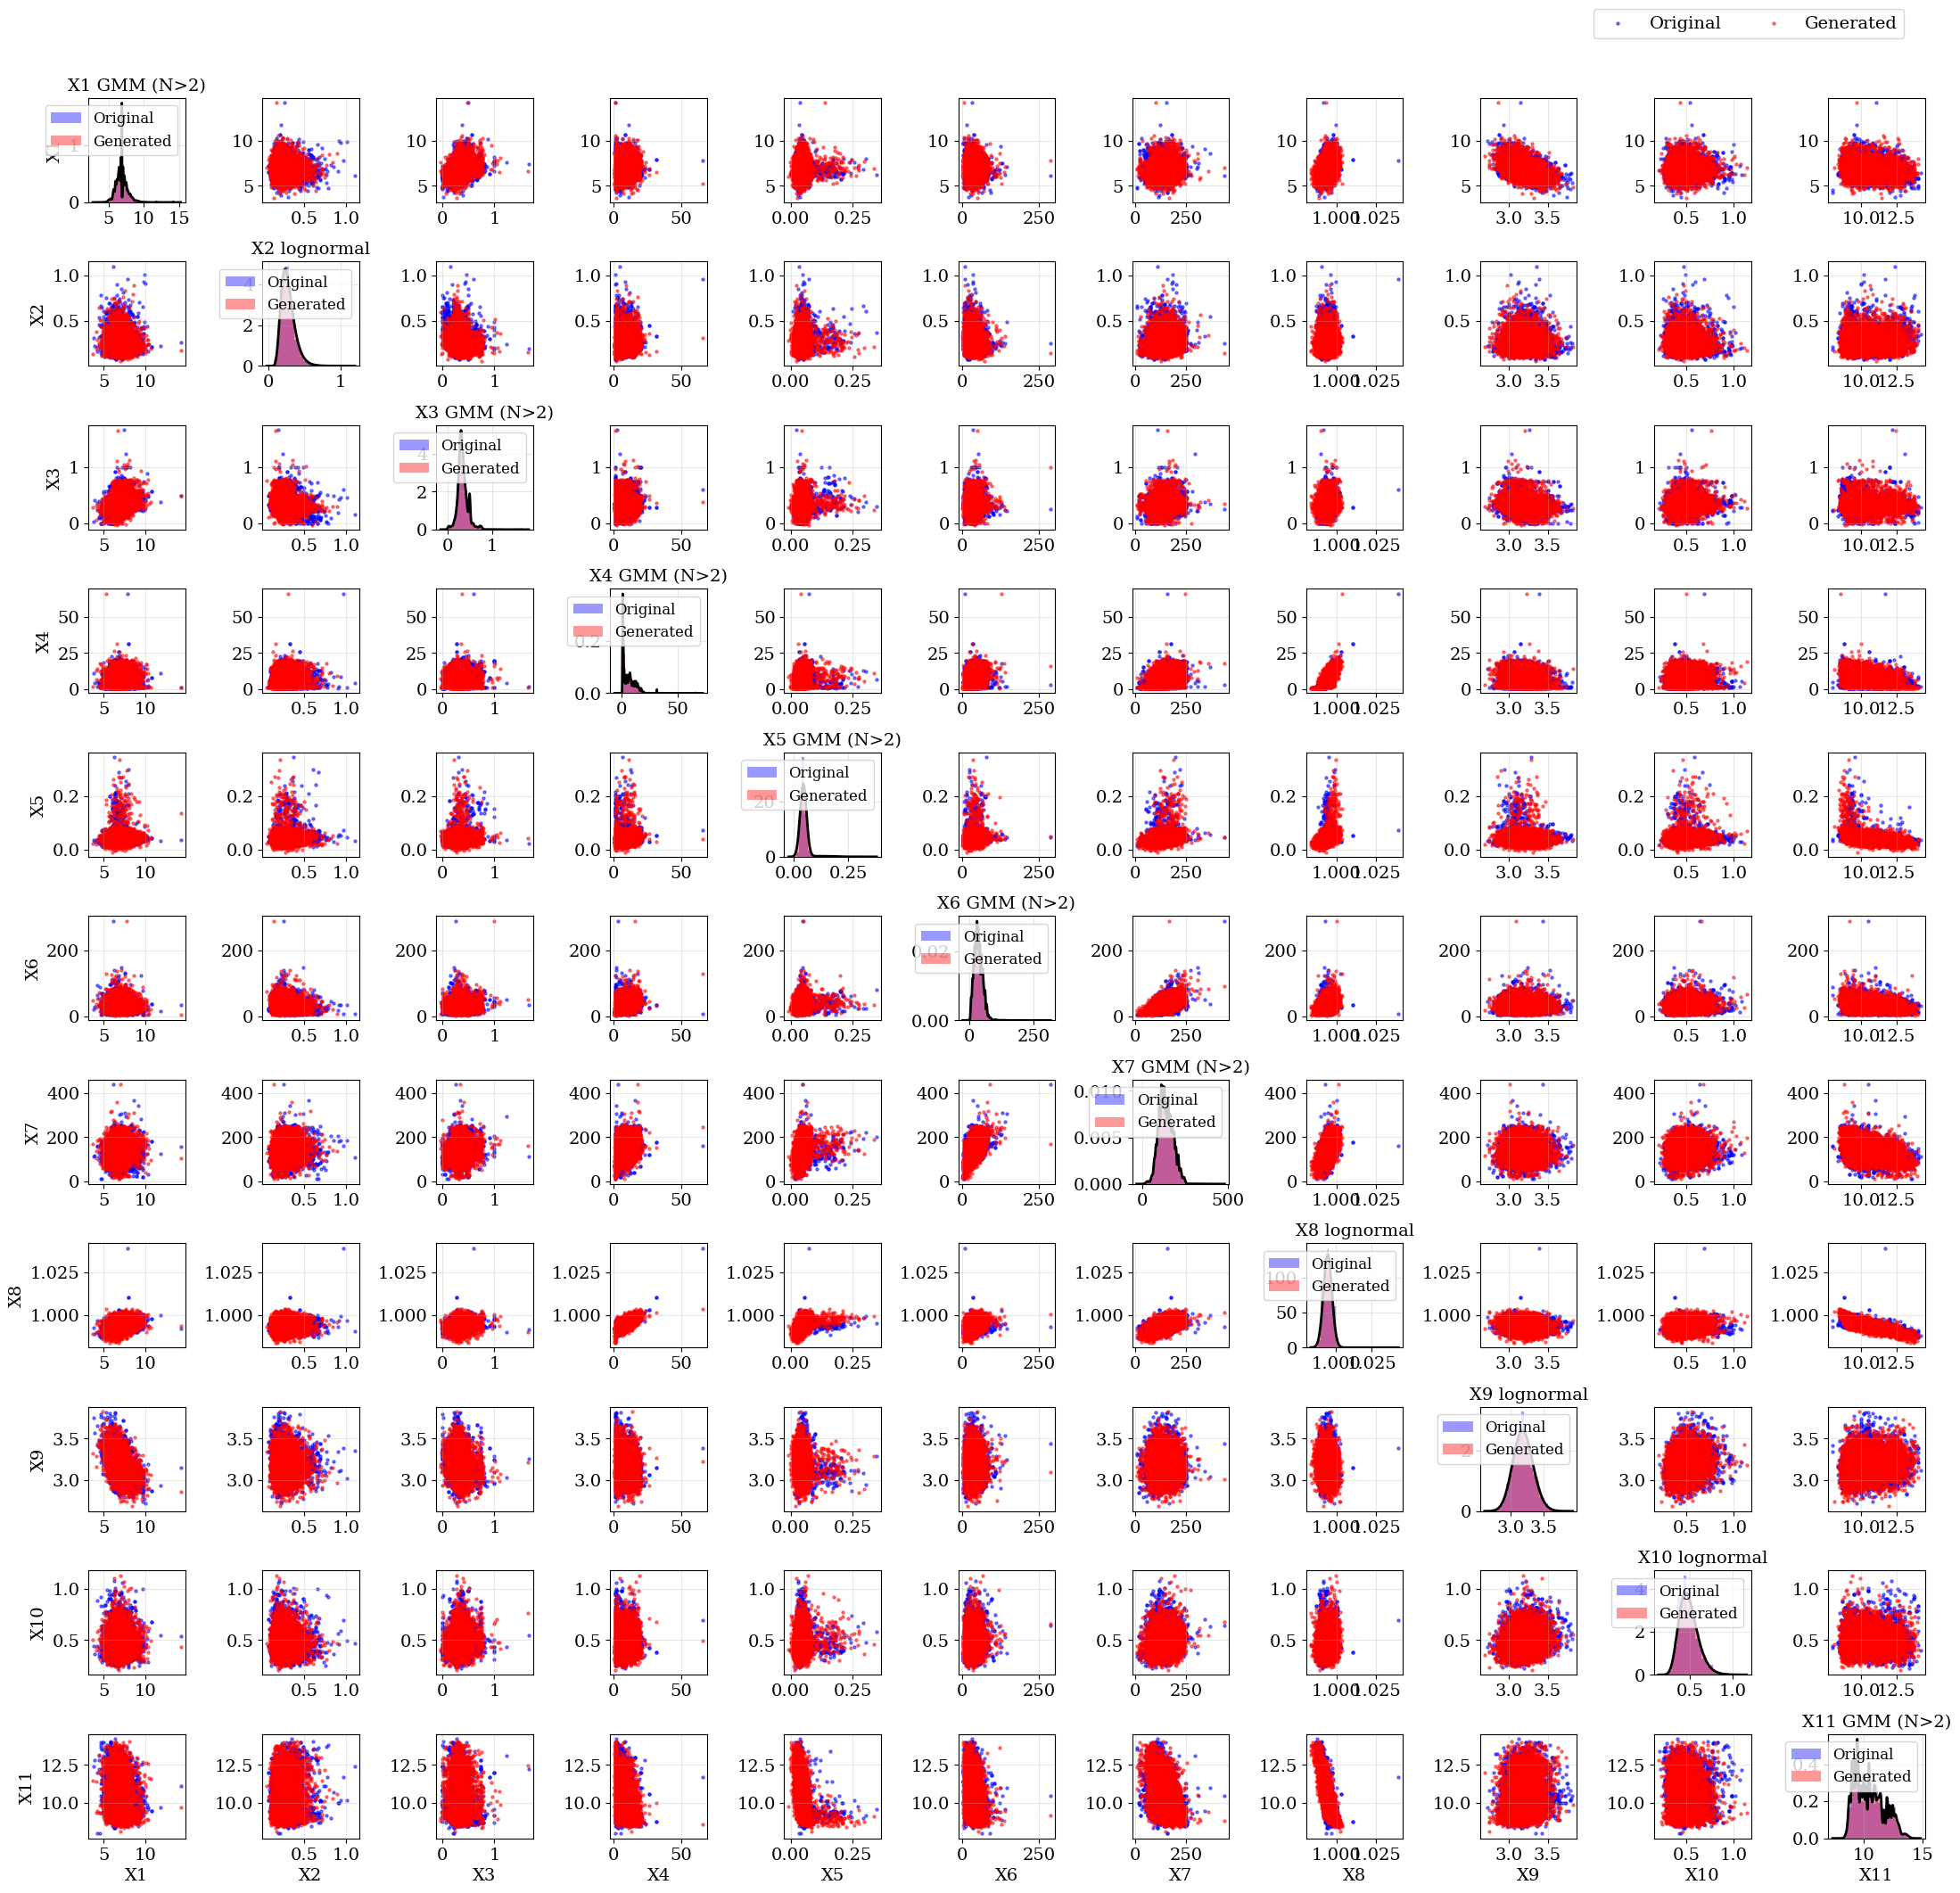

In [ ]:
%%time
visualize_mixed_data3(mixed_samples, data, model, marginals, n_samples=4800)

In [ ]:
from matplotlib import rcParams, rc
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Time New Roman']
fsize = 10
rcParams.update({'font.size': fsize})



def nmodal_normal_pdf(x, params):
    """
    Compute the PDF of an N-modal normal distribution.

    Parameters:
    -----------
    x : array-like
        Points at which to evaluate the PDF
    params : dict
        Dictionary containing parameters for N components:
        - 'modes': number of modes (N)
        - 'loc1', 'loc2', ..., 'locN': means for each component
        - 'scale1', 'scale2', ..., 'scaleN': standard deviations for each component
        - 'weight1', 'weight2', ..., 'weightN': weights for each component
    """
    # Get number of modes
    n_modes = params.get('n_components', 2)  # Default to bimodal if not specified

    # Extract parameters for each mode
    locations = []
    scales = []
    weights = []

    for i in range(1, n_modes + 1):
        locations.append(params.get(f'loc{i}', 0.0))
        scales.append(params.get(f'scale{i}', 1.0))
        weights.append(params.get(f'weight{i}', 1.0/n_modes))

    # Normalize weights to sum to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Compute the mixture of N Gaussians
    pdf_result = np.zeros_like(x, dtype=float)
    for i in range(n_modes):
        pdf_result += weights[i] * stats.norm.pdf(x, loc=locations[i], scale=scales[i])

    return pdf_result

# Helper function for N-modal normal inverse CDF (PPF)
def nmodal_normal_ppf(u, params, n_samples):
    """
    Compute the inverse CDF (percent point function) of an N-modal normal distribution.

    Parameters:
    -----------
    u : torch.Tensor
        Probability values (0 to 1)
    params : dict
        Dictionary containing parameters for N components
    n_samples : int
        Number of samples (unused, kept for API compatibility)

    Returns:
    --------
    torch.Tensor
        The quantile values corresponding to the input probabilities
    """
    # Get number of modes
    n_modes = params.get('n_components', 2)  # Default to bimodal if not specified

    # Extract parameters for each mode
    locations = []
    scales = []
    weights = []

    for i in range(1, n_modes + 1):
        locations.append(params.get(f'loc{i}', 0.0))
        scales.append(params.get(f'scale{i}', 1.0))
        weights.append(params.get(f'weight{i}', 1.0/n_modes))

    # Normalize weights to sum to 1
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Define CDF function for N-modal normal
    def nmodal_cdf(x):
        cdf_sum = 0.0
        for i in range(n_modes):
            cdf_sum += weights[i] * stats.norm.cdf(x, loc=locations[i], scale=scales[i])
        return cdf_sum

    # Implement binary search for each quantile
    result = []
    for uk in u:
        uk_val = uk.item()

        # Set reasonable search bounds
        lower = min([loc - 4*scale for loc, scale in zip(locations, scales)])
        upper = max([loc + 4*scale for loc, scale in zip(locations, scales)])

        # Handle edge cases
        if uk_val <= 0.0:
            result.append(lower)
            continue
        if uk_val >= 1.0:
            result.append(upper)
            continue

        # Binary search
        tol = 1e-6
        max_iter = 100

        for _ in range(max_iter):
            mid = (lower + upper) / 2
            cdf_mid = nmodal_cdf(mid)

            if abs(cdf_mid - uk_val) < tol:
                result.append(mid)
                break
            elif cdf_mid < uk_val:
                lower = mid
            else:
                upper = mid

            if _ == max_iter - 1:  # Last iteration
                result.append((lower + upper) / 2)

    return torch.tensor(result, dtype=torch.float32)


def visualize_mixed_data3(mixed_samples, u_transformed, model=None, marginals=None, n_samples=100):
    """Visualize mixed data with different marginal distributions in a grid of plots."""
    import matplotlib.pyplot as plt
    from scipy import stats
    import numpy as np
    import torch

    n_vars = len(marginals)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars*2, n_vars*2))
    var_names = [f'X{i+1} {m["name"]}' for i, m in enumerate(marginals)]
    var_names_axis = [f'X{i+1}' for i, m in enumerate(marginals)]

    # Helper function for N-modal normal PDF

    # Define distribution PDF and CDF mapping functions
    dist_funcs = {
        'exponential': {
            'pdf': lambda x, p: stats.expon.pdf(x, scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: -torch.log(1 - u) * p.get('scale', 1.0)
        },
        'beta': {
            'pdf': lambda x, p: stats.beta.pdf(x, p.get('a', 1.0), p.get('b', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.beta.ppf(uk.item(), p.get('a', 1.0), p.get('b', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        't': {
            'pdf': lambda x, p: stats.t.pdf((x - p.get('loc', 0)) / p.get('scale', 1), p.get('df', 5)) / p.get('scale', 1),
            'ppf': lambda u, p, n: torch.tensor([stats.t.ppf(uk.item(), p.get('df', 5)) * p.get('scale', 1) + p.get('loc', 0) for uk in u], dtype=torch.float32)
        },
        'gamma': {
            'pdf': lambda x, p: stats.gamma.pdf(x, p.get('shape', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.gamma.ppf(uk.item(), p.get('shape', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'normal': {
            'pdf': lambda x, p: stats.norm.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), p.get('loc', 0.0), p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'lognormal': {
            'pdf': lambda x, p: stats.lognorm.pdf(x, s=p.get('s', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.lognorm.ppf(uk.item(), s=p.get('s', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'weibull': {
            'pdf': lambda x, p: stats.weibull_min.pdf(x, p.get('c', 1.0), scale=p.get('scale', 1.0)),
            'ppf': lambda u, p, n: torch.tensor([stats.weibull_min.ppf(uk.item(), p.get('c', 1.0), scale=p.get('scale', 1.0))
                                               for uk in u], dtype=torch.float32)
        },
        'uniform': {
            'pdf': lambda x, p: stats.uniform.pdf(x, p.get('loc', 0.0), p.get('scale', 1.0) ),
            'ppf': lambda u, p, n: p.get('loc', 0.0) + p.get('scale', 1.0) * u
        },
        'bimodal_normal': {
            'pdf': lambda x, p: nmodal_normal_pdf(x, p),  # Use N-modal function with 2 modes
            'ppf': lambda u, p, n: nmodal_normal_ppf(u, p, n)
        },
        'nmodal_normal': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'gmm (n=2)': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'gmm (n=3)': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'gmm (n=4)': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
        'gmm (n>2)': {
            'pdf': nmodal_normal_pdf,
            'ppf': nmodal_normal_ppf
        },
    }

    # Generate samples from model if provided
    if model is not None:
        with torch.no_grad():
            u_samples = model.sample(n_samples)
            n_feature = mixed_samples.shape[1]
            mixed_generated = torch.zeros([n_samples, n_feature])

            for var_idx in range(n_vars):
                dist_type = marginals[var_idx]['type'].lower()
                params = marginals[var_idx]['params']

                # Get the appropriate ppf function or default to normal
                ppf_func = dist_funcs.get(dist_type, {}).get('ppf',
                                        lambda u, p, n: torch.tensor([stats.norm.ppf(uk.item(), 0, 1)
                                                                     for uk in u], dtype=torch.float32))

                # Apply inverse CDF transformation
                mixed_generated[:, var_idx] = ppf_func(u_samples[:, var_idx], params, n_samples)

    # Plot the grid
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j] if n_vars > 1 else axes

            if i == j:  # Diagonal: histogram and PDF
                # Plot histogram of actual data
                ax.hist(mixed_samples[:, i].numpy(), bins=25, alpha=0.4, density=True, color='blue', label='Original')

                # Plot histogram of generated data if available
                if model is not None:
                    ax.hist(mixed_generated[:, i].numpy(), bins=25, alpha=0.4, density=True, color='red', label='Generated')

                if marginals is not None:
                    try:
                        # Generate x values for PDF plotting
                        x_min, x_max = np.min(mixed_samples[:, i].numpy()), np.max(mixed_samples[:, i].numpy())
                        x_range = x_max - x_min
                        x = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 1000)

                        # Get distribution type and parameters
                        dist_type = marginals[i]['type'].lower()
                        params = marginals[i]['params']

                        # Get the appropriate pdf function or default to None
                        pdf_func = dist_funcs.get(dist_type, {}).get('pdf')

                        # Plot the PDF if available
                        if pdf_func is not None:
                            pdf = pdf_func(x, params)
                            ax.plot(x, pdf, 'k-', lw=2)

                            # For N-modal distributions, plot the individual components
                            if dist_type in ['nmodal_normal', 'nmodal_gaussian', 'multimodal_normal',
                                            'bimodal_normal', 'bimodal_gaussian']:
                                n_modes = params.get('modes', 2)

                                # Extract parameters for each mode
                                locations = []
                                scales = []
                                weights = []

                                for k in range(1, n_modes + 1):
                                    locations.append(params.get(f'loc{k}', 0.0))
                                    scales.append(params.get(f'scale{k}', 1.0))
                                    weights.append(params.get(f'weight{k}', 1.0/n_modes))

                                # Normalize weights
                                total_weight = sum(weights)
                                weights = [w / total_weight for w in weights]


                            ax.legend(loc=1, fontsize=fsize-2)
                    except Exception as e:
                        print(f"Error plotting PDF for {var_names[i]}: {e}")

                ax.set_title(var_names[i], fontsize=fsize)
                ax.grid(True, alpha=0.3)
                # Add axis labels for outer plots
                if i == n_vars-1:  # Bottom row
                    ax.set_xlabel(var_names_axis[j])
                if j == 0:  # Leftmost column
                    ax.set_ylabel(var_names_axis[i])

            else:  # Off-diagonal: scatter plots
                # Plot original data
                ax.scatter(
                    mixed_samples[:, j].numpy(),
                    mixed_samples[:, i].numpy(),
                    alpha=0.5, s=5, color='blue', label='Original'
                )

                # Plot generated data if model is provided
                if model is not None:
                    ax.scatter(
                        mixed_generated[:, j].numpy(),
                        mixed_generated[:, i].numpy(),
                        alpha=0.5, s=5, color='red', label='Generated'
                    )

                # Add grid for better readability
                ax.grid(True, alpha=0.3)

                # Add axis labels for outer plots
                if i == n_vars-1:  # Bottom row
                    ax.set_xlabel(var_names_axis[j])
                if j == 0:  # Leftmost column
                    ax.set_ylabel(var_names_axis[i])

    # Add legend to one plot
    if n_vars > 1:
        handles, labels = axes[0, 1].get_legend_handles_labels()
        fig.legend(handles, labels, loc=1, bbox_to_anchor=(0.98, 0.97), ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for the legend
    plt.savefig('mixed_data_grid.png', dpi=300)
    return None




In [ ]:
class NDimensionalCVineCopula(nn.Module):
    def __init__(self, n_dimensions, copula=GaussianCopula):
        super().__init__()
        self.n_dimensions = n_dimensions

        # We need copulas for each tree level and each pair within that level
        self.copulas = nn.ModuleDict()

        # For each tree level (conditioning variables)
        for tree_level in range(n_dimensions - 1):
            # The root node for this tree is tree_level + 1 (1-indexed)
            root = tree_level + 1

            # For each pair in this tree
            for j in range(root + 1, n_dimensions + 1):
                # Create key based on variables and conditioning variables
                if tree_level == 0:
                    # First tree level has no conditioning
                    key = f"c{root}{j}"
                else:
                    # Other tree levels have conditioning variables
                    conditioning = "".join([str(k) for k in range(1, tree_level + 1)])
                    key = f"c{root}{j}_{conditioning}"

                # Create the copula
                self.copulas[key] = copula()

    def forward(self, u_data):
        batch_size, n_dims = u_data.shape
        log_density = torch.zeros(batch_size, device=device, dtype=torch.float32)
        h_functions = {}

        for tree_level in range(n_dims - 1):
            root = tree_level + 1
            # Precompute conditioning indices up to tree_level
            conditioning = tuple(range(1, tree_level + 1))
            cond_str = "".join(map(str, conditioning)) if conditioning else ""

            for j in range(root + 1, n_dims + 1):
                if tree_level == 0:
                    # Direct copula density computation
                    key = f"c{root}{j}"
                    copula_density = self.copulas[key](u_data[:, root-1], u_data[:, j-1])

                    # Ensure copula_density is positive to avoid log(0)
                    copula_density = copula_density.clamp(min=1e-10)
                    log_density += torch.log(copula_density)

                    # Store h-function
                    h_key = f"F{j}_{root}"
                    for ii in range(5000):
                      h_functions[h_key] = self.copulas[key].h_function(u_data[:, j-1], u_data[:, root-1])
                # else:
                #     # Conditional copula density
                #     h_key_root = f"F{root}_{cond_str}"
                #     h_key_j = f"F{j}_{cond_str}"
                #     key = f"c{root}{j}_{cond_str}"

                #     # Compute copula density using h-functions
                #     # copula_density = self.copulas[key](h_functions[h_key_root], h_functions[h_key_j])
                # #     copula_density = copula_density.clamp(min=1e-10)
                # #     log_density += torch.log(copula_density)

                #     # Compute new h-function if needed
                #     if tree_level < n_dims - 2:
                #         new_cond_str = cond_str + str(root)
                #         h_key = f"F{j}_{new_cond_str}"
                #         h_functions[h_key] = self.copulas[key].h_function(h_functions[h_key_j], h_functions[h_key_root])

        # Return exponentiated log_density
        return log_density.exp()